# **Step 1: convert data to list of dicts from jsonlist**

In [ ]:
def convert_data(mode):
  f = open(mode)
  raw = f.read()
  raw = raw.split('\n')
  data = [0]*len(raw)
  for i in range(len(raw)-1):
    data[i] = json.loads(raw[i])
  del data[-1]
  return data

# **Step 2: create dictionary relating speakers to adjectives to frequency of use**

In [ ]:
import spacy
import json
from spacy.symbols import nsubj, ADJ, NOUN, INTJ, X, VERB

nlp = spacy.load("en_core_web_sm")
data = convert_data('debates.jsonlist')
metadata = convert_data('metadata_debates.jsonlist')

def getYear(url, metadata):
  for j in metadata:
    if j['url'] == url:
      return int(j['date'][-2:])

def getAdjs(debate, adjdict, metadata, pos):
  speeches = debate["speeches"]
  url = debate["url"]
  yr = getYear(url, metadata)
  yr = (yr-1) - (yr-1)%4 + 4
  for speech in speeches:
    doc = nlp(speech["text"][0])
    name = speech["speaker"]+'--'+str(yr)
    if name in adjdict:
      for token in doc:
        if pos == X or token.pos == pos:
          if str(token).lower() in adjdict[name]:
            adjdict[name][str(token).lower()] += 1
          else:
            adjdict[name][str(token).lower()] = 1
    else:
      for token in doc:
        if pos == X or token.pos == pos:
          adjdict[name] = {} 
          adjdict[name][str(token).lower()] = 1 
  return adjdict

def getAllAdjs(data, metadata, pos):
  adjdict = {}
  for debate in data:
    adjdict = getAdjs(debate, adjdict, metadata, pos)
  return adjdict

FileNotFoundError: ignored

In [ ]:
#last param is part of speech being selected, use X for all parts of speech.
adjDict = getAllAdjs(data, metadata, ADJ)

# **Step 3: Filter by general election candidates and clean data:**

In [ ]:
def getYear(url, metadata):
  for j in metadata:
    if j['url'] == url:
      return int(j['date'][-2:])

def parseWhiteList(filename, adjdict, metadata):
  thinnedAdjdict = {}
  f = open(filename, 'r')
  text = f.read()
  text = text.split('\n')[:-1]
  for item in text:
    name1 = item.split('_')[0].lower()
    name2 = item.split('_')[1].lower()
    for n in adjdict:
      if name1 in n.lower() or name2 in n.lower():
        yr = int(n.split('--')[-1])
        if yr == int(item.split('_')[-1]):
          if item in thinnedAdjdict:
            try:
              thinnedAdjdict[item].update(adjdict[n])
            except:
              thinnedAdjdict[item].append(adjdict[n])
          else:
            thinnedAdjdict[item] = adjdict[n]
  return thinnedAdjdict 

In [ ]:
# Store thinned data in dictionary

thinnedAdjdict = parseWhiteList('./presidential_candidates.txt', adjDict, metadata)

# **Step 4: sort new dictionary values by frequency**

In [ ]:
def sortAdjdict(adjdict):
  sortedAdjdict = {}
  for name in adjdict:
    sortedAdjdict[name] = {k: v for k, v in sorted(adjdict[name].items(), key=lambda item: item[1], reverse=True)}
  return sortedAdjdict

sortedAdjdict = sortAdjdict(thinnedAdjdict)

{'John_Kennedy_60': {'the': 140, '.': 109, 'and': 93, ',': 90, 'of': 79, 'to': 67, '—': 54, 'that': 50, 'a': 44, 'in': 34, 'not': 33, 'we': 32, 'is': 31, 'our': 29, 'i': 27, 'on': 22, 'be': 22, 'it': 21, 'are': 21, 'for': 20, 'new': 20, 'his': 18, 'all': 16, 'as': 16, 'but': 16, 'my': 15, 'their': 14, 'have': 13, 'with': 13, 'this': 13, 'frontier': 13, 'can': 12, 'has': 12, 'nation': 11, 'who': 11, 'by': 11, 'party': 10, '"': 10, 'or': 10, 'you': 9, 'will': 9, 'world': 9, 'old': 9, 'shall': 9, 'at': 8, 'me': 8, 'one': 8, 'men': 8, 'now': 8, 'from': 8, "'s": 8, 'am': 7, '-': 7, 'an': 7, 'they': 7, 'more': 7, ';': 7, 'democratic': 6, 'coming': 6, 'many': 6, 'up': 6, 'what': 6, 'its': 6, 'american': 6, 'free': 6, 'your': 6, 'know': 6, 'future': 6, 'into': 6, 'great': 5, 'months': 5, 'without': 5, 'only': 5, 'us': 5, 'platform': 5, 'so': 5, 'no': 5, 'those': 5, 'deal': 5, 'here': 5, 'between': 5, 'today': 5, 'over': 5, 'was': 4, 'first': 4, 'every': 4, 'stand': 4, 'made': 4, 'time': 4, 'pe

# **Step 5: Valence, arousal, and dominance analysis**

In [ ]:
# Create a dictionary of words relating them to their VAD (uses NRC-VAD-Lexicon)

def vadDict():
  vad = {}
  f = open('NRC-VAD-Lexicon.txt', 'r')
  text = f.read()
  lines = text.split('\n')
  for line in lines[:-1]:
    segs = line.split('\t')
    vad[segs[0]] = [segs[1],segs[2],segs[3]]
  return vad

vad = vadDict()

In [ ]:
# Create dictionary that relates speakers to their VADs of the
# words they have used

def speakerVad(adjsDict, vadDict):
  speakerVadDict = {}
  for key in adjsDict:
    adjToVad = {}
    for adj in adjsDict[key]:
      if str(adj) != "applause":
        try: 
          adjToVad[adj] = vadDict[adj]
        except:
          continue
    speakerVadDict[key] = adjToVad
  return speakerVadDict

speakerVadDict = speakerVad(thinnedAdjdict, vad)

NameError: ignored

In [ ]:
# Create dictionary relating speaker to 
# valence/aroudal/dominance values of words used, sorted by value

def vadSorted(speakerVadDict, vadval):
  vadsorted = {}
  for name in speakerVadDict:
    vadsorted[name] = {}
    for word in speakerVadDict[name]:
      vadsorted[name][word] = speakerVadDict[name][word][vadval]
    vadsorted[name] = {k: v for k, v in sorted(vadsorted[name].items(), key=lambda item: item[1])}
  return vadsorted


# **Step 6: reconstruct dictionary in form decided in meeting.** 
That is, a list of dictionaries for each candidate relating them to their name, words used + frequency of use, election year, valence/arousal/dominance of words, and their party

In [ ]:
def getParties(filename):
  f = open(filename, 'r')
  text = f.read()
  text = text.split('\n')
  democrats = {}
  for line in text:
    democrats[line] = True
  return democrats

def reconstructDict(adjdict, speakerVadDict):
  adjdictlist = []
  valence = vadSorted(speakerVadDict, 0)
  arousal = vadSorted(speakerVadDict, 1)
  dominance = vadSorted(speakerVadDict, 2)
  for name in adjdict:
    year = 0
    party = "r"
    if int(name[-2:]) < 22:
      year = int("20"+name[-2:])
    else:
      year = int("19"+name[-2:])
    if name in getParties('candidate_parties.txt'):
      party = 'd'
    adjdictlist.append({
        "speaker" : name,
        "freq_dict" : adjdict[name],
        "year" : year,
        "valence" : valence[name],
        "arousal" : arousal[name],
        "dominance" : dominance[name],
        "party" : party
    })
  return adjdictlist

adjdictlist = reconstructDict(sortedAdjdict, speakerVadDict)

In [ ]:
# Step 6.5: Save work
# Save dictionary as json

def saveDict(filename, adjdict):
  f = open(filename, 'a')
  for pres in adjdict:
    f.write(json.dumps(pres)+"\n")
  f.close()

In [ ]:
saveDict('./convention_speeches_candidate_all.jsonl', reconstructDict(sortedAdjdict, speakerVadDict))

In [1]:
# Load json as dictionary

import json

def loadDict(filename):
  adjdictlist = []
  f = open(filename, 'r')
  text = f.read()
  text = text.split("\n")
  for line in text[:-1]:
    adjdictlist.append(json.loads(line))
  f.close()
  return adjdictlist

#adjdictlist = loadDict('./debates_candidate_adjectives.jsonl')
adjdictlist = loadDict('./outgroup_debates_adjs.jsonl')

# **Step 7: Graph**

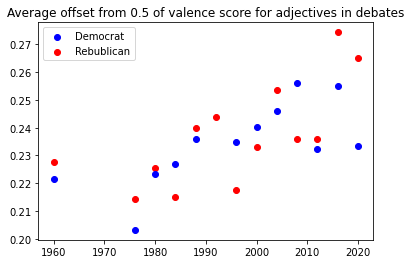

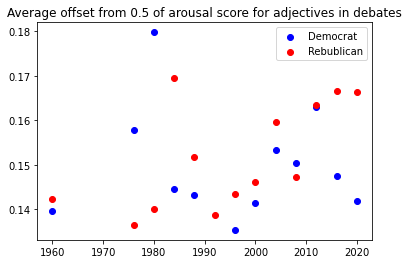

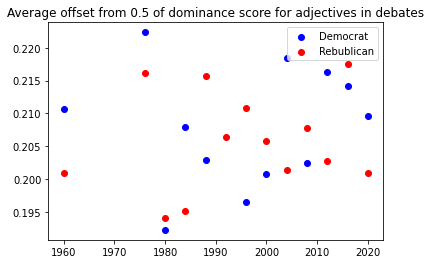

In [6]:
import statistics
import matplotlib.pyplot as plt
import pandas as pd

# metric functions

def meanfunc(values):
  values = [float(x) for x in values]
  return sum(values)/len(values)

def abs_meanfunc(values):
  values = [abs(float(x) - 0.5) for x in values]
  return sum(values)/len(values)

def maxfunc(values):
  values = [float(x) for x in values]
  return max(values)

def mean_of_top_n(values, n = 0.1):
  values = [float(x) for x in values]
  values.sort(reverse = True)
  return sum(values[:round(len(values)*n)])/round(len(values)*n)

def mean_of_bottom_n(values, n = 0.1):
  values = [float(x) for x in values]
  values.sort()
  return sum(values[:round(len(values)*n)])/round(len(values)*n)

def variancefunc(values):
  values = [float(x) for x in values]
  try:
    return statistics.variance(values)
  except:
    return 0

def nothing(values):
  values = [float(x) for x in values]
  return values

# Plot functions
def applyMetricToData(metric, adjdictlist):
  X_data = {}
  y_data = {}
  for e in ['valence', 'arousal', 'dominance']:
    for entry in adjdictlist:
      vals = []
      words = list(entry[e].keys())
      freq = entry['freq_dict']
      for word in words:
        for i in range(freq[word]):
          vals.append(entry[e][word])
      X_data[entry["speaker"]] = entry["year"]
      y_data[entry["speaker"]] = metric(vals)
      c = 'red'
      if entry["party"] == 'd':
        c = 'blue'
      plt.scatter(entry["year"], metric(vals), color = c)
    plt.title("Average offset from 0.5 of "+ e + " score for adjectives in debates")
    plt.legend(['Democrat', 'Rebublican'])
    plt.show()

def box_plot(adjdictlist):
  reps_data = {}
  dems_data = {}
  for e in ['valence', 'arousal', 'dominance']:
    for entry in adjdictlist:
      vals = []
      words = list(entry[e].keys())
      freq = entry['freq_dict']
      for word in words:
        for i in range(freq[word]):
          vals.append(entry[e][word])
      if entry["party"] == 'd':
        dems_data[entry["speaker"]] = nothing(vals)
      else:
        reps_data[entry["speaker"]] = nothing(vals)
      c = 'red'
      if entry["party"] == 'd':
        c = 'blue'
    datad = []
    datar = []
    for name in dems_data:
      datad.append(dems_data[name])
    for name in reps_data:
      datar.append(reps_data[name]) 
    plt.boxplot(datad, patch_artist=True, boxprops=dict(facecolor="blue"), positions=[1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
    plt.title("boxplots for adjectives from debates republicans")
    plt.show()
    plt.boxplot(datar, patch_artist=True, boxprops=dict(facecolor="red"), positions=[1960, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
    plt.title("boxplots for adjectives from debates democrats")
    plt.show()

applyMetricToData(abs_meanfunc, adjdictlist)
#box_plot(adjdictlist)

# **End of VAD analysis**

In [ ]:
# Step 8: analyze sentence progression
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 27.4 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
import json
from spacy.lang.en import English
from spacy.symbols import nsubj, ADJ, NOUN, INTJ, X, VERB

nlp = spacy.load("en_core_web_sm")
data = convert_data('debates.jsonlist')
metadata = convert_data('metadata_debates.jsonlist')

def getYear(url, metadata):
  for j in metadata:
    if j['url'] == url:
      return int(j['date'][-2:])
  
# adapted from https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict

# adapted from https://stackoverflow.com/questions/58516766/sentence-split-using-spacy-sentenizer
def getSents(debate, sentDict, metadata):
  speeches = debate["speeches"]
  url = debate["url"]
  yr = getYear(url, metadata)
  yr = (yr-1) - (yr-1)%4 + 4
  for speech in speeches:
    nlp = English()
    sbd = nlp.create_pipe('sentencizer')
    nlp.add_pipe(sbd)
    doc = nlp(speech["text"][0])
    name = speech["speaker"]+'--'+str(yr)
    if name in sentDict:
      for sent in doc.sents:
        sentDict[name].append(sent.text)
    else:
      sentences = list(doc.sents)
      if sentences:
        sentDict[name] = [sentences[0].text]
      if len(sentences) > 1:
        for sent in sentences[1:]:
          sentDict[name].append(sent.text)
  return sentDict

def getAllSents(data, metadata):
  sentDict = {}
  for debate in data:
    sentDict = getSents(debate, sentDict, metadata)
  return sentDict



FileNotFoundError: ignored

In [ ]:
sentDict = getAllSents(data, metadata)

In [ ]:
thinnedSentdict = parseWhiteList('./presidential_candidates.txt', sentDict, metadata)
print(thinnedSentdict['John_Kennedy_60']) 

['MR.', 'KENNEDY: Good evening, Mr. Howe.', 'MR.', 'KENNEDY: Mr. Howe, Mr. Vice President.', 'First uh - let me again try to correct the record on the matter of Quemoy and Matsu.', 'I voted for the Formosa resolution in 1955.', 'I have sustained it since then.', "I've said that I agree with the Administration policy.", 'Mr. Nixon earlier indicated that he would defend Quemoy and Matsu even if the attack on these islands, two miles off the coast of China, were not part of a general attack an Formosa and the Pescadores.', 'I indicated that I would defend those islands if the attack were directed against Pescadores and Formosa, which is part of the Eisenhower policy.', "I've supported that policy.", 'In the last week, as a member of the Senate Foreign Relations Committee, I have re-read the testimony of General Twining representing the Administration in 1959, and the Assistant Secretary of State before the Foreign Relations Committee in 1958, and I have accurately described the Administra

In [ ]:
def reconstructDict(sentdict):
  sentdictlist = []
  for name in sentdict:
    year = 0
    party = "r"
    sid_obj = SentimentIntensityAnalyzer()
    if int(name[-2:]) < 22:
      year = int("20"+name[-2:])
    else:
      year = int("19"+name[-2:])
    if name in getParties('candidate_parties.txt'):
      party = 'd'
    vader_sents = []
    for sent in sentdict[name]:
      sentiment_dict = sid_obj.polarity_scores(sent)
      vader_sents.append(sentiment_dict)
    sentdictlist.append({
        "speaker" : name,
        "year" : year,
        "sents" : sentdict[name],
        "vader_sents" : vader_sents,
        "party" : party
    })
  return sentdictlist

sentdictlist = reconstructDict(thinnedSentdict)

In [ ]:
print(sentdictlist[0])

{'speaker': 'John_Kennedy_60', 'year': 1960, 'sents': ['MR.', 'KENNEDY: Good evening, Mr. Howe.', 'MR.', 'KENNEDY: Mr. Howe, Mr. Vice President.', 'First uh - let me again try to correct the record on the matter of Quemoy and Matsu.', 'I voted for the Formosa resolution in 1955.', 'I have sustained it since then.', "I've said that I agree with the Administration policy.", 'Mr. Nixon earlier indicated that he would defend Quemoy and Matsu even if the attack on these islands, two miles off the coast of China, were not part of a general attack an Formosa and the Pescadores.', 'I indicated that I would defend those islands if the attack were directed against Pescadores and Formosa, which is part of the Eisenhower policy.', "I've supported that policy.", 'In the last week, as a member of the Senate Foreign Relations Committee, I have re-read the testimony of General Twining representing the Administration in 1959, and the Assistant Secretary of State before the Foreign Relations Committee i

In [ ]:
saveDict('./debates_sentences.jsonl', sentdictlist)

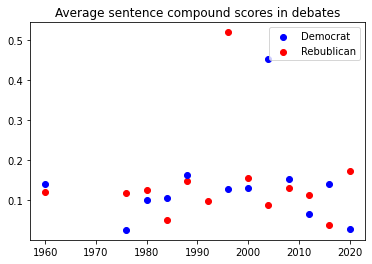

In [ ]:
def abs_meanfunc_sents(values):
  values = [abs(float(x)) for x in values]
  return sum(values)/len(values)

def plot_sentence_vader(sentdictlist):
  X = []
  y = []
  for pres in sentdictlist:
    X.append(pres["year"])

def applyMetricToSentenceData(metric, adjdictlist):
  X_data = {}
  y_data = {}
  for entry in adjdictlist:
      vals = []
      scores = list(entry["vader_sents"])
      for i in range(len(scores)):
        scores[i] = scores[i]["compound"] #change for different scores
      X_data[entry["speaker"]] = entry["year"]
      y_data[entry["speaker"]] = metric(scores)
      c = 'red'
      if entry["party"] == 'd':
        c = 'blue'
      plt.scatter(entry["year"], metric(scores), color = c)
  plt.title("Average sentence compound scores in debates")
  plt.legend(['Democrat', 'Rebublican'])
  plt.show()

applyMetricToSentenceData(meanfunc, sentdictlist)

In [ ]:
# Part 9 most common n-grams
# sourced from https://gist.github.com/benhoyt/dfafeab26d7c02a52ed17b6229f0cb52

import collections
import re
import sys
import time


def tokenize(string):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    return re.findall(r'\w+', string.lower())


def count_ngrams(lines, min_length=2, max_length=4):
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    # Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams


def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-grams -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')



In [ ]:
def get_texts(data, metadata):
  ngrams_dict = {}
  for document in data:
    url = document["url"]
    yr = getYear(url, metadata)
    yr = (yr-1) - (yr-1)%4 + 4
    speeches = document["speeches"]
    for speech in speeches:
      name = speech["speaker"]+'--'+str(yr)
      speech_merged = ""
      for text in speech["text"]:
        speech_merged += text
      speech_merged = speech_merged.split('\n')
      if name not in ngrams_dict:
        ngrams_dict[name] = count_ngrams(speech_merged)
      else:
        count = count_ngrams(speech_merged)
        for key in count:
          if key in ngrams_dict[name]:
            ngrams_dict[name][key].update(count[key])
          else:
            ngrams_dict[name][key] = count[key]
        #ngrams_dict[name].update(count_ngrams(speech_merged))
  return ngrams_dict

In [ ]:
ngrams_dict = get_texts(data, metadata)

In [ ]:
def parseWhiteListNgram(filename, adjdict, metadata):
  thinnedAdjdict = {}
  f = open(filename, 'r')
  text = f.read()
  text = text.split('\n')[:-1]
  for item in text:
    thinnedAdjdict[item] = {}
    name1 = item.split('_')[0].lower()
    name2 = item.split('_')[1].lower()
    for i in range(2,5):  
      thinnedAdjdict[item].update({i : {}})
      for n in adjdict:
        if name1 in n.lower() or name2 in n.lower():
          yr = int(n.split('--')[-1])
          if yr == int(item.split('_')[-1]):
              if item in thinnedAdjdict:
                    thinnedAdjdict[item][i].update(adjdict[n][i])
                  # except:
                  #   thinnedAdjdict[item][i].append(adjdict[n])
              else:
                thinnedAdjdict[item][i] = adjdict[n][i]
  return thinnedAdjdict 
thinned_ngrams = parseWhiteListNgram('./presidential_candidates.txt', ngrams_dict, metadata)

In [ ]:
def sort_ngrams(ngram_dict):
  for name in ngram_dict:
    for n in ngram_dict[name]:
      ngram_dict[name][n] = {k: v for k, v in sorted(ngram_dict[name][n].items(), key=lambda item: item[1], reverse = True)}
  return ngram_dict
sorted_thinned_ngrams = sort_ngrams(thinned_ngrams)

In [ ]:
def get_x_most_common_n_gram(ngram_dict, name, x, n):
  most_common = []
  keys = list(ngram_dict[name][n].keys())
  for i in range(x):
    most_common.append([keys[i], ngram_dict[name][n][keys[i]]])
  return most_common

In [ ]:
get_x_most_common_n_gram(sorted_thinned_ngrams, 'Donald_Trump_20', 10, 2)

[[('it', 's'), 109],
 [('don', 't'), 82],
 [('going', 'to'), 72],
 [('we', 'have'), 68],
 [('that', 's'), 50],
 [('we', 're'), 48],
 [('look', 'at'), 48],
 [('didn', 't'), 48],
 [('you', 'know'), 47],
 [('you', 're'), 47]]